<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Notebook comparing diaSources from preconvolution+filtering vs template convolution</b> <br>
Contact author: Ian Sullivan<br>
Last verified to run: 28 September 2023<br>
LSST Science Piplines version: w_2023_38 and d_2023_09_22<br>
Run with a local ap_verify run of ap_verify_ci_hits2015


## Run details

Baseline run in comparison with pre-convolution

* Used weekly `w_2023_38` for the base, d_2023_09_22 for the test after DM-39796 merged
* No local branches
* Run at USDF, in `/sdf/home/s/sullii/project/tickets/DM-40949`



### 1. Main package imports

In [1]:
import os
import importlib
import pprint

In [2]:
import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

import numpy as np
import pandas as pd

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [4]:
import lsst.afw.display as afwDisplay
import lsst.geom

import lsst.daf.butler as dafButler
import lsst.pipe.base

In [5]:
!setup -r ../../build/analysis_ap -j

setup: /home/s/sullii/notebooks/build/analysis_ap doesn't seem to exist


In [6]:
!eups list analysis_ap

   LOCAL:/home/s/sullii/project/build/analysis_ap 	setup


In [7]:
from lsst.analysis.ap import apdb

In [8]:
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import nb_utils

In [9]:
from astropy.table import Table

In [10]:
importlib.reload(plac)

<module 'lsst.analysis.ap.legacyPlotUtils' from '/home/s/sullii/project/build/analysis_ap/python/lsst/analysis/ap/legacyPlotUtils.py'>

In [11]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

<module 'lsst.analysis.ap.legacyApdbUtils' from '/home/s/sullii/project/build/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py'>

### 2. Data access config
We are comparing multiple runs now, so we have to define where to find the data and the APDBs for each run.

#### Keys for default run.

In [12]:
!ls "../../../project/tickets/DM-40949/w_2023_38/"

alerts	association.db	config	pipelines  repo


In [13]:
repo = '../../../project/tickets/DM-40949/w_2023_38/repo/'
collections = 'ap_verify-output'
instrument = 'DECam'
skymap = 'decam_rings_v1'

butler = dafButler.Butler(repo, collections=collections)

dbType='sqlite'
dbName = "../../../project/tickets/DM-40949/w_2023_38/association.db"

reader = apdb.ApdbSqliteQuery(dbName, butler=butler, instrument='DECam')

In [14]:
len(reader._tables)

5

In [15]:
default_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [16]:
default_run['run_name'] = 'Default'

#### This set is for preconvolution using the code from `w_2023_34`

In [17]:
repo = '../../../project/tickets/DM-40949/d_2023_09_22/repo/'
collections = 'ap_verify-output'
instrument = 'DECam'
skymap = 'decam_rings_v1'

butler = dafButler.Butler(repo, collections=collections)

dbType='sqlite'
dbName="../../../project/tickets/DM-40949/d_2023_09_22/association.db"

reader = apdb.ApdbSqliteQuery(dbName, butler=butler, instrument='DECam')

In [18]:
test_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [19]:
test_run['run_name'] = 'Post-merge'

## A. Analysis of Sources

### 3. Number of detections
Now loading the tables to compare among them

In [20]:
default_run['robjTable'] = default_run['reader'].load_objects()
default_run['rsrcTable'] = default_run['reader'].load_sources()

In [21]:
test_run['robjTable'] = test_run['reader'].load_objects()
test_run['rsrcTable'] = test_run['reader'].load_sources()

Look at how many objects and sources we picked right from the reader

In [22]:
n_objs = pd.DataFrame()

In [23]:
n_objs.loc['default', 'n_rdiasrc'] = len(default_run['rsrcTable'])
n_objs.loc['test', 'n_rdiasrc'] = len(test_run['rsrcTable'])

In [24]:
n_objs.loc['default', 'n_rdiaobj'] = len(default_run['robjTable'])
n_objs.loc['test', 'n_rdiaobj'] = len(test_run['robjTable'])

In [25]:
n_objs

,n_rdiasrc,n_rdiaobj
default,1178.0,991.0
test,1174.0,995.0


In [26]:
test_table2 = test_run['reader'].load_sources()

In [27]:
object_columns = ['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean', 
                  'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
                  'validityEnd', 'flags']

In [28]:
source_columns = ['diaSourceId', 'diaObjectId', 'ra', 'dec', 'ccdVisitId', 'midpointMjdTai',
                  'apFlux', 'psfFlux', 'apFluxErr', 'psfFluxErr', 'scienceFlux', 'scienceFluxErr',
                  'snr', 'x', 'y', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'flags', 'reliability', 'band',
                  'visit', 'detector', 'instrument']

In [29]:
table1 = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()]

Inspect the columns of the object table

In [30]:
for c in table1.columns:
    print(c)

diaObjectId
validityStart
validityEnd
ra
raErr
dec
decErr
ra_dec_Cov
radecMjdTai
pmRa
pmRaErr
pmDec
pmDecErr
parallax
parallaxErr
pmRa_pmDec_Cov
pmRa_parallax_Cov
pmDec_parallax_Cov
pmParallaxLnL
pmParallaxChi2
pmParallaxNdata
u_psfFluxMean
u_psfFluxMeanErr
u_psfFluxSigma
u_psfFluxChi2
u_psfFluxNdata
u_fpFluxMean
u_fpFluxMeanErr
u_fpFluxSigma
g_psfFluxMean
g_psfFluxMeanErr
g_psfFluxSigma
g_psfFluxChi2
g_psfFluxNdata
g_fpFluxMean
g_fpFluxMeanErr
g_fpFluxSigma
r_psfFluxMean
r_psfFluxMeanErr
r_psfFluxSigma
r_psfFluxChi2
r_psfFluxNdata
r_fpFluxMean
r_fpFluxMeanErr
r_fpFluxSigma
i_psfFluxMean
i_psfFluxMeanErr
i_psfFluxSigma
i_psfFluxChi2
i_psfFluxNdata
i_fpFluxMean
i_fpFluxMeanErr
i_fpFluxSigma
z_psfFluxMean
z_psfFluxMeanErr
z_psfFluxSigma
z_psfFluxChi2
z_psfFluxNdata
z_fpFluxMean
z_fpFluxMeanErr
z_fpFluxSigma
y_psfFluxMean
y_psfFluxMeanErr
y_psfFluxSigma
y_psfFluxChi2
y_psfFluxNdata
y_fpFluxMean
y_fpFluxMeanErr
y_fpFluxSigma
u_lcPeriodic
g_lcPeriodic
r_lcPeriodic
i_lcPeriodic
z_lcPeriodic


Inspect the columns of the source table

In [31]:
table2 = default_run['rsrcTable']

In [32]:
for c in table2.columns:
    print(c)

diaSourceId
ccdVisitId
diaObjectId
ssObjectId
parentDiaSourceId
ssObjectReassocTime
midpointMjdTai
ra
raErr
dec
decErr
ra_dec_Cov
x
xErr
y
yErr
x_y_Cov
apFlux
apFluxErr
snr
psfFlux
psfFluxErr
psfRa
psfRaErr
psfDec
psfDecErr
psfFlux_psfRa_Cov
psfFlux_psfDec_Cov
psfRa_psfDec_Cov
psfLnL
psfChi2
psfNdata
trailFlux
trailFluxErr
trailRa
trailRaErr
trailDec
trailDecErr
trailLength
trailLengthErr
trailAngle
trailAngleErr
trailFlux_trailRa_Cov
trailFlux_trailDec_Cov
trailFlux_trailLength_Cov
trailFlux_trailAngle_Cov
trailRa_trailDec_Cov
trailRa_trailLength_Cov
trailRa_trailAngle_Cov
trailDec_trailLength_Cov
trailDec_trailAngle_Cov
trailLength_trailAngle_Cov
trailLnL
trailChi2
trailNdata
dipoleMeanFlux
dipoleMeanFluxErr
dipoleFluxDiff
dipoleFluxDiffErr
dipoleRa
dipoleRaErr
dipoleDec
dipoleDecErr
dipoleLength
dipoleLengthErr
dipoleAngle
dipoleAngleErr
dipoleMeanFlux_dipoleFluxDiff_Cov
dipoleMeanFlux_dipoleRa_Cov
dipoleMeanFlux_dipoleDec_Cov
dipoleMeanFlux_dipoleLength_Cov
dipoleMeanFlux_dipoleAng

In [33]:
ccdVisitIds = set(table2['ccdVisitId'])

In [34]:
ccdVisitIds

{41137156, 41137160, 41142005, 41142010, 41980205, 41980210}

Now filter the objects which are not valid and pick the useful columns.

In [35]:
default_run['objTable'] = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()][object_columns]
test_run['objTable'] = test_run['robjTable'][test_run['robjTable'].validityEnd.isnull()][object_columns]

In [36]:
default_run['srcTable'] = default_run['rsrcTable'][source_columns]
test_run['srcTable'] = test_run['rsrcTable'][source_columns]

Check numbers once more

In [37]:
n_objs.loc['default', 'n_diasrc'] = len(default_run['srcTable'])
n_objs.loc['test', 'n_diasrc'] = len(test_run['srcTable'])

In [38]:
n_objs.loc['default', 'n_diaobj'] = len(default_run['objTable'])
n_objs.loc['test', 'n_diaobj'] = len(test_run['objTable'])

In [39]:
n_objs

,n_rdiasrc,n_rdiaobj,n_diasrc,n_diaobj
default,1178.0,991.0,1178.0,991.0
test,1174.0,995.0,1174.0,995.0


Note that no objects were filtered out by the above check - not true this time!

### 4. Flags 
Loading up the flag tables now

In [40]:
badFlagList = [
    'base_PixelFlags_flag_bad',
    'base_PixelFlags_flag_suspect',
    'base_PixelFlags_flag_saturatedCenter',
    'base_PixelFlags_flag_interpolated',
    'base_PixelFlags_flag_interpolatedCenter',
    'base_PixelFlags_flag_edge'
    ]

In [41]:
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

In [42]:
import functools
import operator

In [43]:
config = TransformDiaSourceCatalogConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')

In [44]:
def add_flag_tables(run_dict, badFlagList):
    """
    Unpack the flags and add the resulting tables to the run dictionary
    """
    run_dict['flagValues'] = unpacker.unpack(run_dict['srcTable']['flags'], 'flags')
    run_dict['flagTable'] = pd.DataFrame(run_dict['flagValues'], index=run_dict['srcTable'].index)

    run_dict['srcTableFlags'] = pd.merge(run_dict['srcTable'], run_dict['flagTable'], left_index=True, right_index=True)
    
    badFlags = [run_dict['srcTableFlags'][flag] for flag in badFlagList]
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter

    run_dict['goodSrc'] = run_dict['srcTableFlags'].loc[noFlagFilter]

    run_dict['goodObjIds'] = set(run_dict['srcTableFlags'].loc[noFlagFilter, 'diaObjectId'])

    run_dict['goodObj'] = run_dict['objTable'].loc[run_dict['objTable']['diaObjectId'].isin(run_dict['goodObjIds'])]
    
    return flagFilter, noFlagFilter

In [45]:
flagFilter, noFlagFilter = add_flag_tables(default_run, badFlagList)
flagFilter1, noFlagFilter1 = add_flag_tables(test_run, badFlagList)

In [46]:
n_objs.loc['default', 'n_good_diaobj'] = len(default_run['goodObj'])
n_objs.loc['test', 'n_good_diaobj'] = len(test_run['goodObj'])

In [47]:
n_objs.loc['default', 'n_good_diasrc'] = len(default_run['goodSrc'])
n_objs.loc['test', 'n_good_diasrc'] = len(test_run['goodSrc'])

In [48]:
n_objs

,n_rdiasrc,n_rdiaobj,n_diasrc,n_diaobj,n_good_diaobj,n_good_diasrc
default,1178.0,991.0,1178.0,991.0,428.0,560.0
test,1174.0,995.0,1174.0,995.0,432.0,559.0


Text(0, 0.5, 'N')

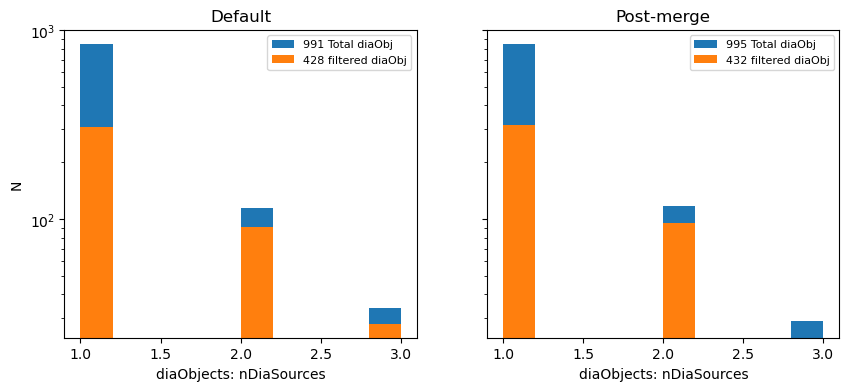

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i_run, run_dict in enumerate([default_run, test_run]):
    #plt.figure(figsize=(12, 8))
    ax = axes.flatten()[i_run]

    ax.hist(run_dict['objTable'].nDiaSources, log=True, label=f"{len(run_dict['objTable'])} Total diaObj")
    #plt.xlabel('diaObjects: nDiaSources')
    #plt.legend(loc='best')

    ax.hist(run_dict['goodObj'].nDiaSources, log=True, label=f"{len(run_dict['goodObj'])} filtered diaObj")
    ax.set_xlabel('diaObjects: nDiaSources')
    ax.legend(loc='best', fontsize=8)
    ax.set_title(run_dict['run_name'])
axes.flatten()[0].set_ylabel('N')

Small differences in good objects, a moderate difference in the total number of objects

## 4.1 Real-bogus reliability scores

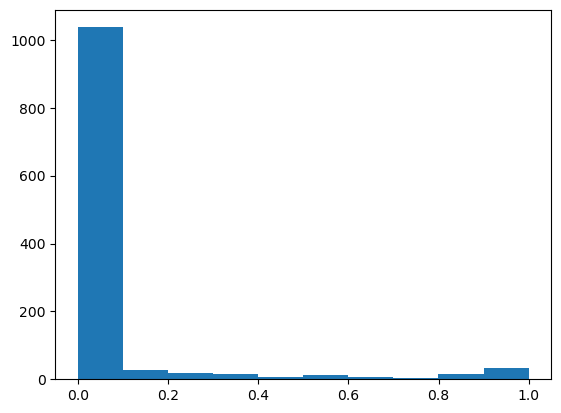

In [50]:
default_hist = plt.hist(default_run['srcTable']['reliability'])

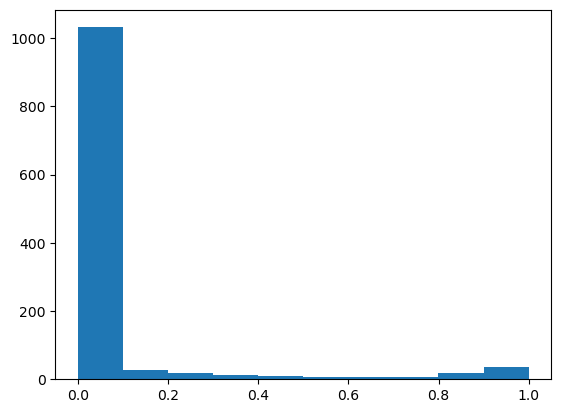

In [51]:
test_hist = plt.hist(test_run['srcTable']['reliability'])

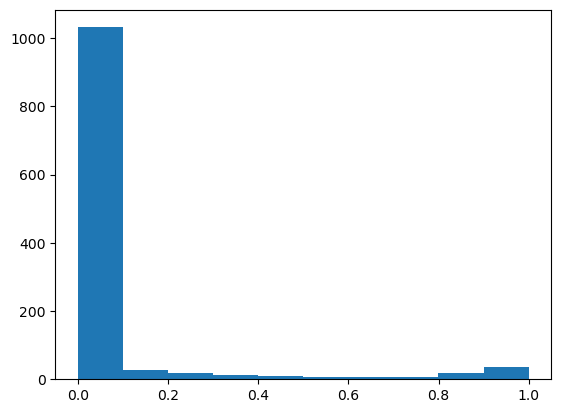

In [52]:
test_hist = plt.hist(test_run['srcTable']['reliability'])

In [53]:
reliability_table = pd.DataFrame()

In [54]:
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)

In [55]:
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[test_run['run_name']] = test_hist[0]

In [56]:
reliability_table

,reliability,Default,Post-merge
0,0.0,1037.0,1032.0
1,0.1,28.0,26.0
2,0.2,18.0,19.0
3,0.3,16.0,14.0
4,0.4,6.0,10.0
5,0.5,13.0,8.0
6,0.6,7.0,6.0
7,0.7,4.0,6.0
8,0.8,15.0,17.0
9,0.9,34.0,36.0


In [57]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(test_hist[0][5:]))

0.49991050574962714
73.0
73.0


From the above table, there is a small change in the total number of diaSources with "good" reliability (above 0.5) between the pipeline default and using preconvolution, and negligible differences between the new and old implementation of preconvolution. The significant change is with the number of diaSources with the worst reliability scores, indicating that the new version of preconvolution is eliminating spurious detections.

### Repeat with only good sources

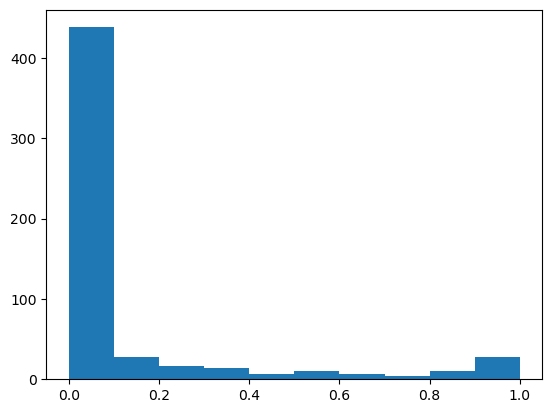

In [58]:
default_hist = plt.hist(default_run['goodSrc']['reliability'])

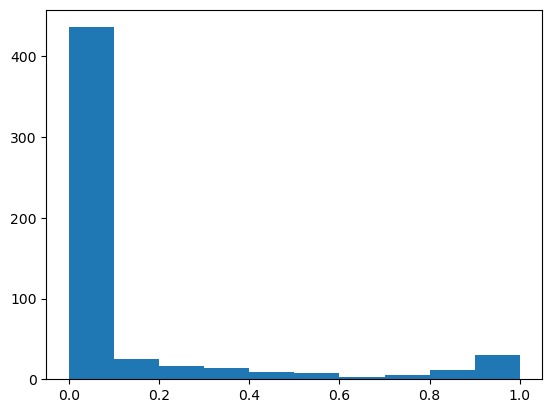

In [59]:
test_hist = plt.hist(test_run['goodSrc']['reliability'])

In [60]:
reliability_table = pd.DataFrame()

In [61]:
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)

In [62]:
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[test_run['run_name']] = test_hist[0]

In [63]:
reliability_table

,reliability,Default,Post-merge
0,0.0,438.0,436.0
1,0.1,28.0,25.0
2,0.2,16.0,17.0
3,0.3,14.0,14.0
4,0.4,6.0,9.0
5,0.5,10.0,8.0
6,0.6,6.0,3.0
7,0.7,4.0,5.0
8,0.8,10.0,12.0
9,0.9,28.0,30.0


In [64]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(test_hist[0][5:]))

0.49991061426307226
58.0
58.0


There is much less of a difference seen between the objects that are flagged as "good". 

## 5. Sky plots on sources

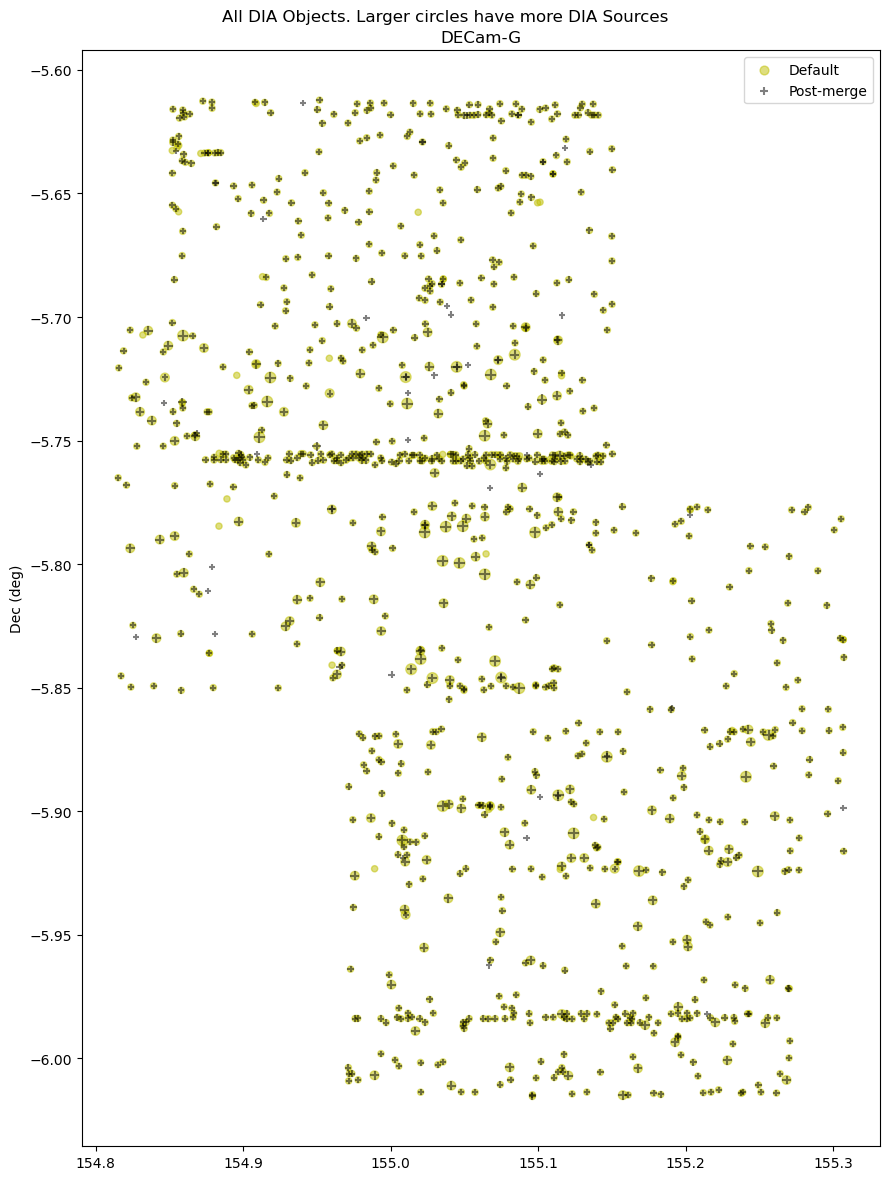

In [65]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, test_run]):

#     xlim = [149.7, 149.5]
#     ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodFilter = (run_dict['objTable']['nDiaSources'] > nSrc)
#     goodFilter = run_dict[]
    
#     axG = axs[i_run]
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']

    ax.scatter(run_dict['objTable'].loc[goodFilter, 'ra'],
               run_dict['objTable'].loc[goodFilter, 'dec'],
               s=run_dict['objTable'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

In [66]:
table_test = run_dict['goodObj']

In [67]:
table_test.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean',
       'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

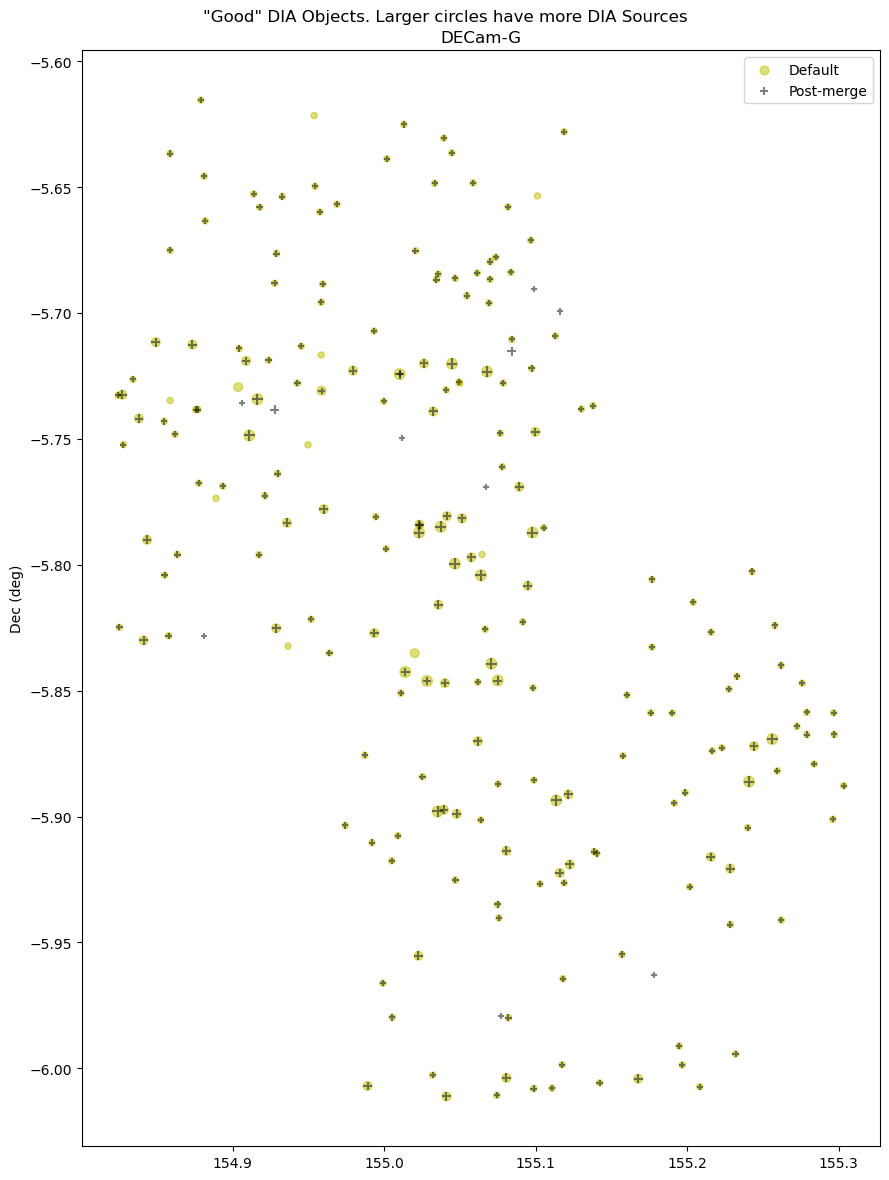

In [68]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, test_run]):

#     xlim = [149.7, 149.5]
#     ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodFilter = (run_dict['goodObj']['nDiaSources'] > nSrc) &\
                 (run_dict['goodObj']['g_psfFluxMean'] > 0)
#     goodFilter = run_dict[]
    
#     axG = axs[i_run]
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']

    ax.scatter(run_dict['goodObj'].loc[goodFilter, 'ra'],
               run_dict['goodObj'].loc[goodFilter, 'dec'],
               s=run_dict['goodObj'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

There are few differences between the old and new implementations of preconvolution when looking at all of the "good" diaObjects, with any number of diaSources. There are no differences between the two runs when restricting to only "good" diaObjects with more than one diaSource.

## 4.2 Comparison of diaSources between runs

In [69]:
objectTable1 = default_run['goodObj']
objectTable2 = test_run['goodObj']

In [70]:
objectTable1.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean',
       'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

In [71]:
obj_default, obj_test, obj_match = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                            default_run['reader'], test_run['reader'],
                                                            match_radius=0.2, display_cutouts=False,
                                                            bad_flag_list=badFlagList,
                                                            make_cutouts=True,
                                                            cutout_path1='../../../project/tickets/DM-40949/cutouts_default',
                                                            cutout_path2='../../../project/tickets/DM-40949/cutouts_test')

508 matched sources; 52 unique to set 1; 52 unique to set 2.


obj_default_all, obj_test_all, obj_match_all = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                                        default_run['reader'], test_run['reader'],
                                                                        match_radius=0.2, display_cutouts=False,
                                                                        bad_flag_list=None,
                                                                        make_cutouts=True,
                                                                        cutout_path1='../../../project/tickets/DM-40949/cutouts_all_default',
                                                                        cutout_path2='../../../project/tickets/DM-40949/cutouts_all_test')

In [72]:
highObs_default = obj_default.diaSourceId[obj_default['reliability'] > 0.1]

In [73]:
highObs_test = obj_test.diaSourceId[obj_test['reliability'] > 0.1]

In [74]:
len(highObs_default)

16

In [75]:
len(highObs_test)

18

## 6. Cutouts

### 7. Flag frequency analysis

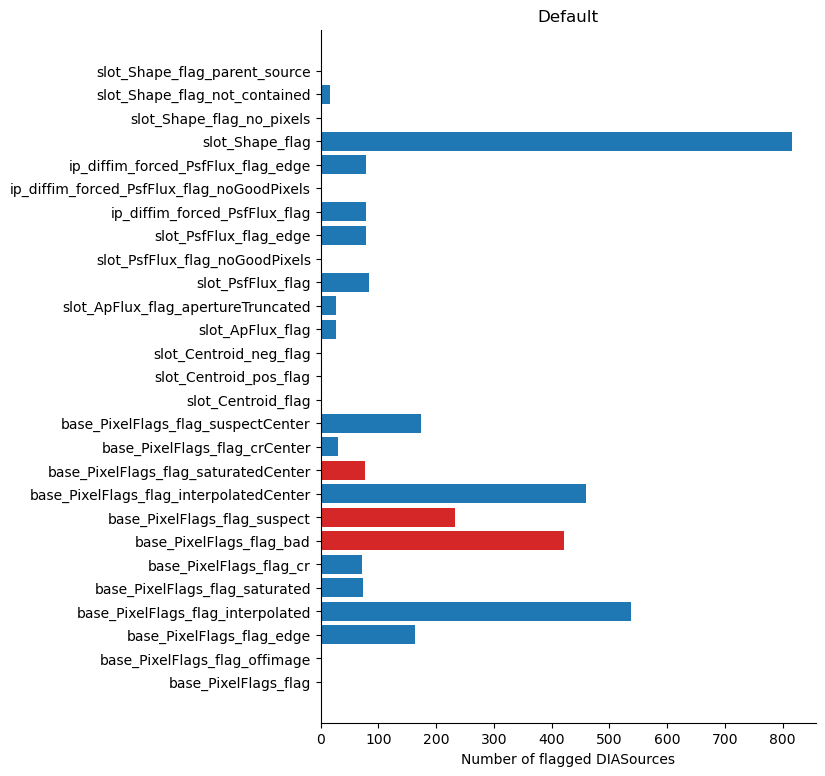

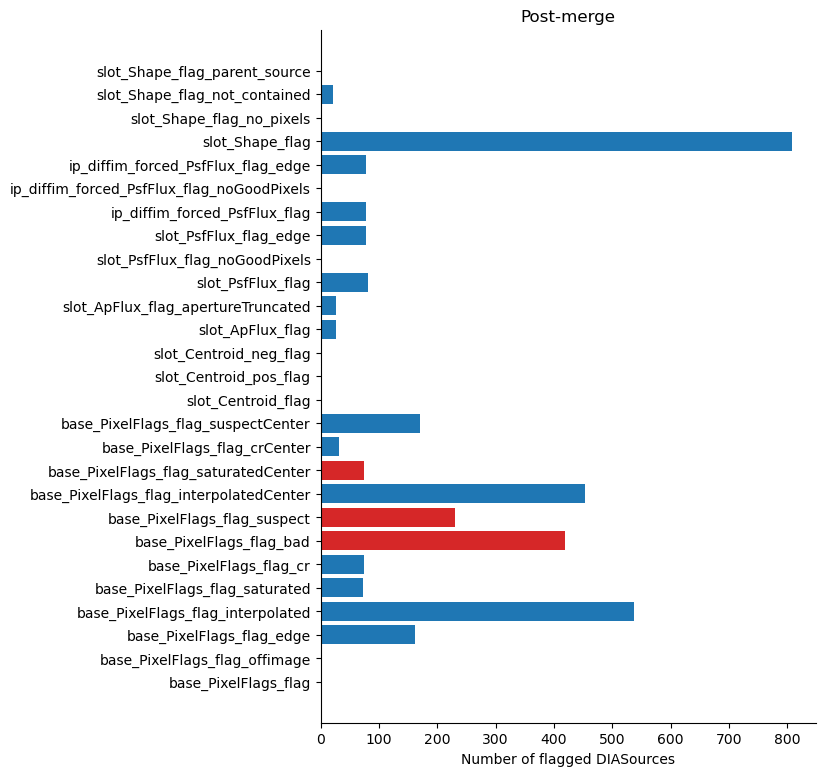

In [76]:
for arun in [default_run, test_run]:
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    
    plac.plotFlagHist(srcTable, title=f'{arun["run_name"]}')

### 8. diaSource reliability score

Not really part of this ticket, but since we have all the sources available let's compare diaSource reliability scores from real-bogus between runs.

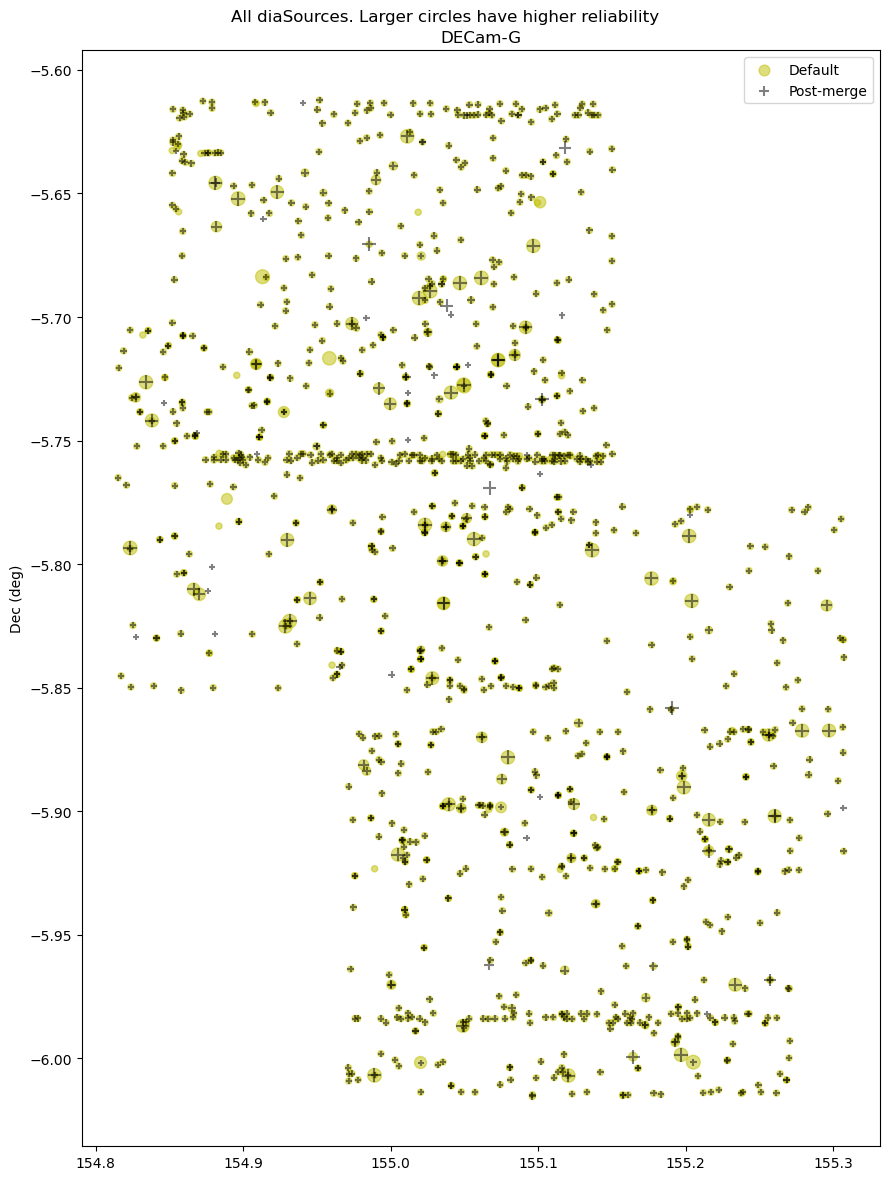

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([default_run, test_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['srcTable']['reliability']*100
    sizes = [max([s, 20]) for s in sizes]

    ax.scatter(run_dict['srcTable']['ra'],
               run_dict['srcTable']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

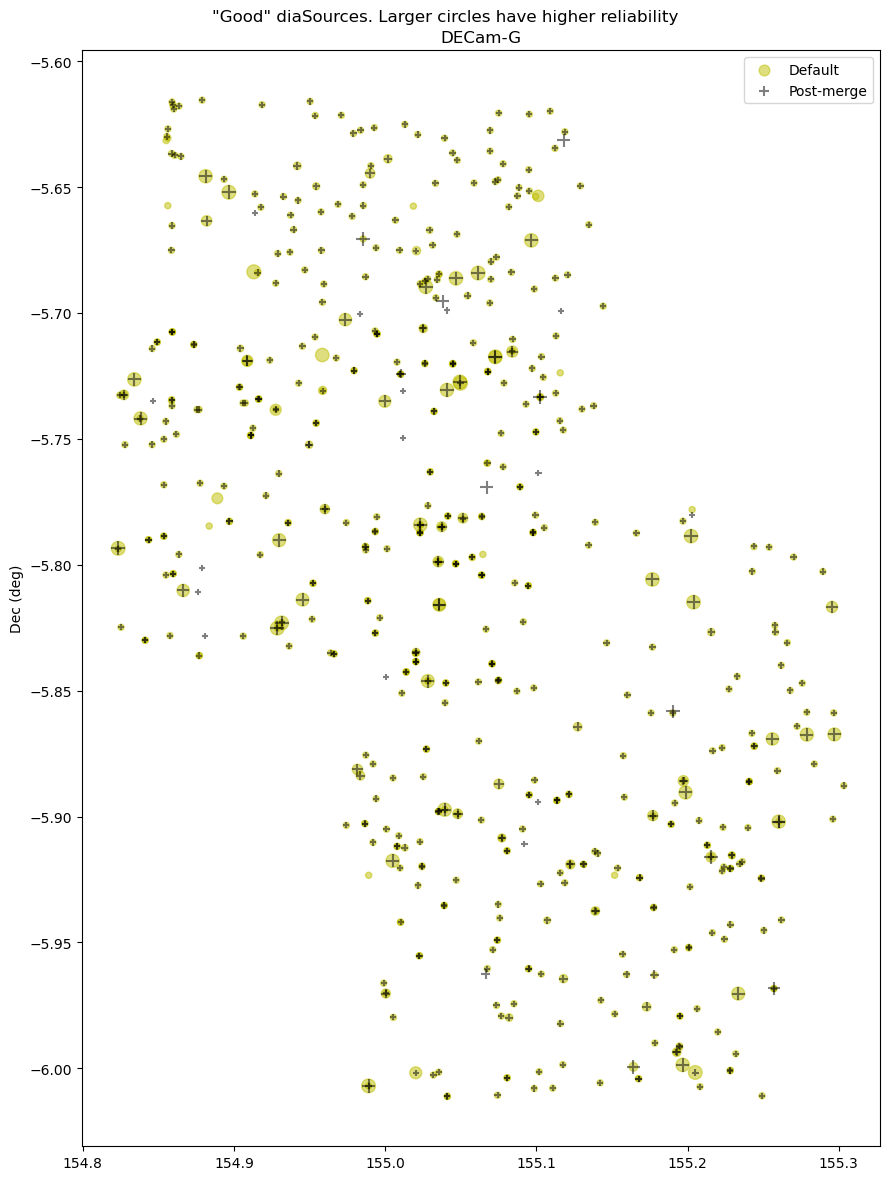

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([default_run, test_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['goodSrc']['reliability']*100
    sizes = [max([s, 20]) for s in sizes]

    ax.scatter(run_dict['goodSrc']['ra'],
               run_dict['goodSrc']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

A few observations on the above scores of "good" diaSources
* In general, the agreement between runs appears excellent.
* There are noticeably more "good" sources detected with the standard template-convolved difference image than with preconvolution.
* There are *more* high reliability diaSources that are missing matched sources. From a quick visual comparison to the previous figure, it is clear that several of these sources do have matches, but they are flagged.